# Cross-Domain Inference: Landcover Model on 0.5m Mangrove Data

Run the landcover.ai-trained SegFormer (5 classes) on our private 0.5m mangrove dataset.

**Model**: SegFormer trained on Landcover.ai v1
- 5 output classes: Background, Building, Woodland, Water, Road

**Target Dataset**: 0.5m resolution mangrove imagery
- Binary ground truth: Not Mangrove (0), Mangrove (1), Ignore (255)
- 512x512 tiles stored as .npy

**Goal**: See how the landcover model interprets mangrove imagery — which landcover classes
does it assign to mangrove vs non-mangrove regions?

## 1. Setup and Configuration

In [1]:
import sys
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from tqdm import tqdm

# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATA_ROOT = Path('../data/0_5m')
WEIGHTS_DIR = Path('../weights')
PLOTS_DIR = Path('../plots/landcover_05m_inference')

# Data files
IMAGES_FILE = DATA_ROOT / '512dataset_images.npy'
LABELS_FILE = DATA_ROOT / '512dataset_labels.npy'

# Model: landcover-trained SegFormer (5 classes)
MODEL_NAME = 'segformer'
WEIGHTS_FILE = WEIGHTS_DIR / 'human_segformer.pth'
NUM_CLASSES = 5  # Landcover model outputs 5 classes

BATCH_SIZE = 16
NUM_WORKERS = 0
IGNORE_INDEX = 255

# Landcover class definitions (model output)
LANDCOVER_NAMES = ['background', 'building', 'woodland', 'water', 'road']
LANDCOVER_COLORS = {
    0: [0.8, 0.8, 0.8],  # Background - gray
    1: [1.0, 0.0, 0.0],  # Building - red
    2: [0.0, 0.5, 0.0],  # Woodland - dark green
    3: [0.0, 0.0, 1.0],  # Water - blue
    4: [1.0, 1.0, 0.0],  # Road - yellow
}

# Mangrove class definitions (ground truth)
MANGROVE_NAMES = ['not_mangrove', 'mangrove']
MANGROVE_COLORS = {
    0: [0.8, 0.8, 0.8],  # Not mangrove - gray
    1: [0.0, 0.7, 0.0],  # Mangrove - green
}

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Model: {MODEL_NAME} (5-class landcover)")
print(f"Weights: {WEIGHTS_FILE}")
print(f"Target data: {DATA_ROOT}")

Device: cuda
Model: segformer (5-class landcover)
Weights: ..\weights\human_segformer.pth
Target data: ..\data\0_5m


## 2. Load Model

In [2]:
sys.path.insert(0, '../../')

from models import SegFormer

print("=== Loading Landcover Model ===")
print()

model = SegFormer(num_classes=NUM_CLASSES)

if WEIGHTS_FILE.exists():
    state_dict = torch.load(WEIGHTS_FILE, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Loaded weights: {WEIGHTS_FILE}")
else:
    raise FileNotFoundError(f"Weights not found: {WEIGHTS_FILE}")

model = model.to(device)
model.eval()

print(f"\nModel: {MODEL_NAME}")
print(f"Output classes: {NUM_CLASSES} ({LANDCOVER_NAMES})")

c:\Users\adytc\anaconda3\envs\mangrove\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Loading Landcover Model ===



Loading weights: 100%|██████████| 364/364 [00:00<00:00, 1128.14it/s, Materializing param=encoder.patch_embeddings.3.proj.weight]            
SegformerModel LOAD REPORT from: nvidia/segformer-b2-finetuned-ade-512-512
Key                                           | Status     |  | 
----------------------------------------------+------------+--+-
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | UNEXPECTED |  | 
decode_head.classifier.bias                   | UNEXPECTED |  | 
decode_head.batch_norm.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.num_batches_tracked    | UNEXPECTED |  | 
decode_head.classifier.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.running_mean           | UNEXPECTED |  | 
decode_head.batch_norm.bias                   | UNEXPECTED |  | 
decode_head.batch_norm.running_var            | UNEXPECTED |  | 
decode_head.linear_fuse.weight                | UNEXPECTED |  | 

Not

Loaded weights: ..\weights\human_segformer.pth

Model: segformer
Output classes: 5 (['background', 'building', 'woodland', 'water', 'road'])


## 3. Load Mangrove Dataset

In [3]:
class MangroveDataset(Dataset):
    """Load 0.5m mangrove .npy data for inference."""
    
    MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __init__(self, images_path, labels_path, indices=None):
        self.images = np.load(images_path, mmap_mode='r')
        self.labels = np.load(labels_path, mmap_mode='r')
        self.indices = indices if indices is not None else np.arange(len(self.images))
        print(f"Loaded {len(self.indices)} samples")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        
        image = self.images[real_idx].copy()
        label = self.labels[real_idx].copy()
        
        image = torch.from_numpy(image).float()
        if image.max() > 1.5:
            image = image / 255.0
        image = (image - self.MEAN) / self.STD
        
        label = torch.from_numpy(label).long()
        if label.dim() == 3:
            label = label.squeeze(0)
        
        return image, label, real_idx


print("=== Loading Mangrove Dataset ===")
print()

# Load all samples
dataset = MangroveDataset(IMAGES_FILE, LABELS_FILE)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nTotal samples: {len(dataset):,}")
print(f"Batches: {len(loader):,}")

=== Loading Mangrove Dataset ===

Loaded 573 samples

Total samples: 573
Batches: 36


## 4. Run Batch Inference

In [4]:
print("=== Running Inference ===")
print()

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks, _ in tqdm(loader, desc="Inference"):
        images = images.to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # 5-class argmax
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

torch.cuda.empty_cache()

print(f"\nPredictions shape: {all_preds.shape}")
print(f"Targets shape: {all_targets.shape}")
print(f"Prediction classes present: {np.unique(all_preds).tolist()}")

=== Running Inference ===



Inference: 100%|██████████| 36/36 [16:08<00:00, 26.90s/it]



Predictions shape: (573, 512, 512)
Targets shape: (573, 512, 512)
Prediction classes present: [0, 1, 2, 3, 4]


## 5. Class Distribution Analysis

What landcover classes does the model assign to mangrove imagery?

In [5]:
print("=== Prediction Class Distribution ===")
print()

preds_flat = all_preds.flatten()
targets_flat = all_targets.flatten()

# Overall prediction distribution
total_pixels = len(preds_flat)
print(f"Total pixels: {total_pixels:,}")
print()
print("Overall prediction distribution:")
print(f"{'Class':<12} {'Count':>12} {'Percentage':>10}")
print("-" * 36)

pred_counts = {}
for c in range(NUM_CLASSES):
    count = (preds_flat == c).sum()
    pct = count / total_pixels * 100
    pred_counts[c] = count
    print(f"{LANDCOVER_NAMES[c]:<12} {count:>12,} {pct:>9.1f}%")

=== Prediction Class Distribution ===

Total pixels: 150,208,512

Overall prediction distribution:
Class               Count Percentage
------------------------------------
background     77,985,735      51.9%
building        2,470,689       1.6%
woodland       37,407,224      24.9%
water          30,584,704      20.4%
road            1,760,160       1.2%


In [6]:
# Breakdown: what does the model predict for mangrove vs non-mangrove pixels?
print("=== Predictions Conditioned on Ground Truth ===")
print()

for gt_class, gt_name in enumerate(MANGROVE_NAMES):
    mask = targets_flat == gt_class
    if mask.sum() == 0:
        continue
    
    gt_preds = preds_flat[mask]
    gt_total = len(gt_preds)
    
    print(f"Where ground truth = {gt_name} ({gt_total:,} pixels):")
    for c in range(NUM_CLASSES):
        count = (gt_preds == c).sum()
        pct = count / gt_total * 100
        bar = '#' * int(pct / 2)
        print(f"  → {LANDCOVER_NAMES[c]:<12}: {pct:>5.1f}%  {bar}")
    print()

# Also show ignore pixels
ignore_mask = targets_flat == IGNORE_INDEX
if ignore_mask.sum() > 0:
    ignore_preds = preds_flat[ignore_mask]
    ignore_total = len(ignore_preds)
    print(f"Where ground truth = ignore/255 ({ignore_total:,} pixels):")
    for c in range(NUM_CLASSES):
        count = (ignore_preds == c).sum()
        pct = count / ignore_total * 100
        print(f"  → {LANDCOVER_NAMES[c]:<12}: {pct:>5.1f}%")

=== Predictions Conditioned on Ground Truth ===

Where ground truth = not_mangrove (68,394,240 pixels):
  → background  :  43.8%  #####################
  → building    :   0.6%  
  → woodland    :  23.5%  ###########
  → water       :  30.2%  ###############
  → road        :   1.9%  

Where ground truth = mangrove (40,731,534 pixels):
  → background  :  40.4%  ####################
  → building    :   0.1%  
  → woodland    :  52.1%  ##########################
  → water       :   7.3%  ###
  → road        :   0.1%  

Where ground truth = ignore/255 (41,082,738 pixels):
  → background  :  76.9%
  → building    :   4.9%
  → woodland    :   0.2%
  → water       :  16.9%
  → road        :   1.0%


=== Plotting Class Distribution ===



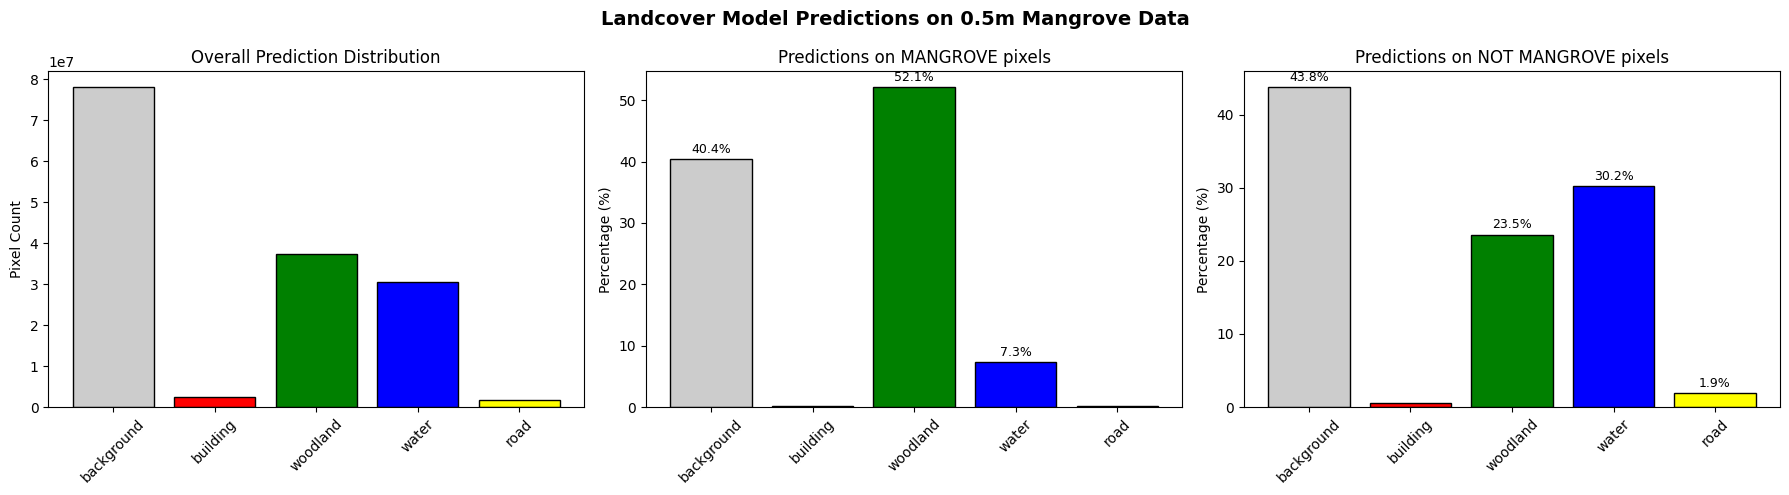

Saved: ..\plots\landcover_05m_inference\class_distribution.png


In [7]:
# Visualize class distribution
print("=== Plotting Class Distribution ===")
print()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Landcover Model Predictions on 0.5m Mangrove Data', fontsize=14, fontweight='bold')

colors = [LANDCOVER_COLORS[i] for i in range(NUM_CLASSES)]

# 1. Overall prediction distribution
counts = [pred_counts[c] for c in range(NUM_CLASSES)]
axes[0].bar(LANDCOVER_NAMES, counts, color=colors, edgecolor='black')
axes[0].set_title('Overall Prediction Distribution')
axes[0].set_ylabel('Pixel Count')
axes[0].tick_params(axis='x', rotation=45)

# 2. Predictions where GT = mangrove
mangrove_mask = targets_flat == 1
if mangrove_mask.sum() > 0:
    mangrove_preds = preds_flat[mangrove_mask]
    m_counts = [(mangrove_preds == c).sum() for c in range(NUM_CLASSES)]
    m_pcts = [c / len(mangrove_preds) * 100 for c in m_counts]
    bars = axes[1].bar(LANDCOVER_NAMES, m_pcts, color=colors, edgecolor='black')
    for bar, pct in zip(bars, m_pcts):
        if pct > 1:
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[1].set_title('Predictions on MANGROVE pixels')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].tick_params(axis='x', rotation=45)

# 3. Predictions where GT = not_mangrove
nonmangrove_mask = targets_flat == 0
if nonmangrove_mask.sum() > 0:
    nm_preds = preds_flat[nonmangrove_mask]
    nm_counts = [(nm_preds == c).sum() for c in range(NUM_CLASSES)]
    nm_pcts = [c / len(nm_preds) * 100 for c in nm_counts]
    bars = axes[2].bar(LANDCOVER_NAMES, nm_pcts, color=colors, edgecolor='black')
    for bar, pct in zip(bars, nm_pcts):
        if pct > 1:
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[2].set_title('Predictions on NOT MANGROVE pixels')
    axes[2].set_ylabel('Percentage (%)')
    axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / 'class_distribution.png'}")

## 6. Visualize Predictions

In [8]:
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)


def mask_to_rgb(mask, class_colors, ignore_index=None):
    """Convert class mask to RGB."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3))
    for class_id, color in class_colors.items():
        rgb[mask == class_id] = color
    if ignore_index is not None:
        rgb[mask == ignore_index] = [1.0, 1.0, 1.0]  # White for ignore
    return rgb


print("Visualization functions defined")

Visualization functions defined


=== Grid Visualization ===



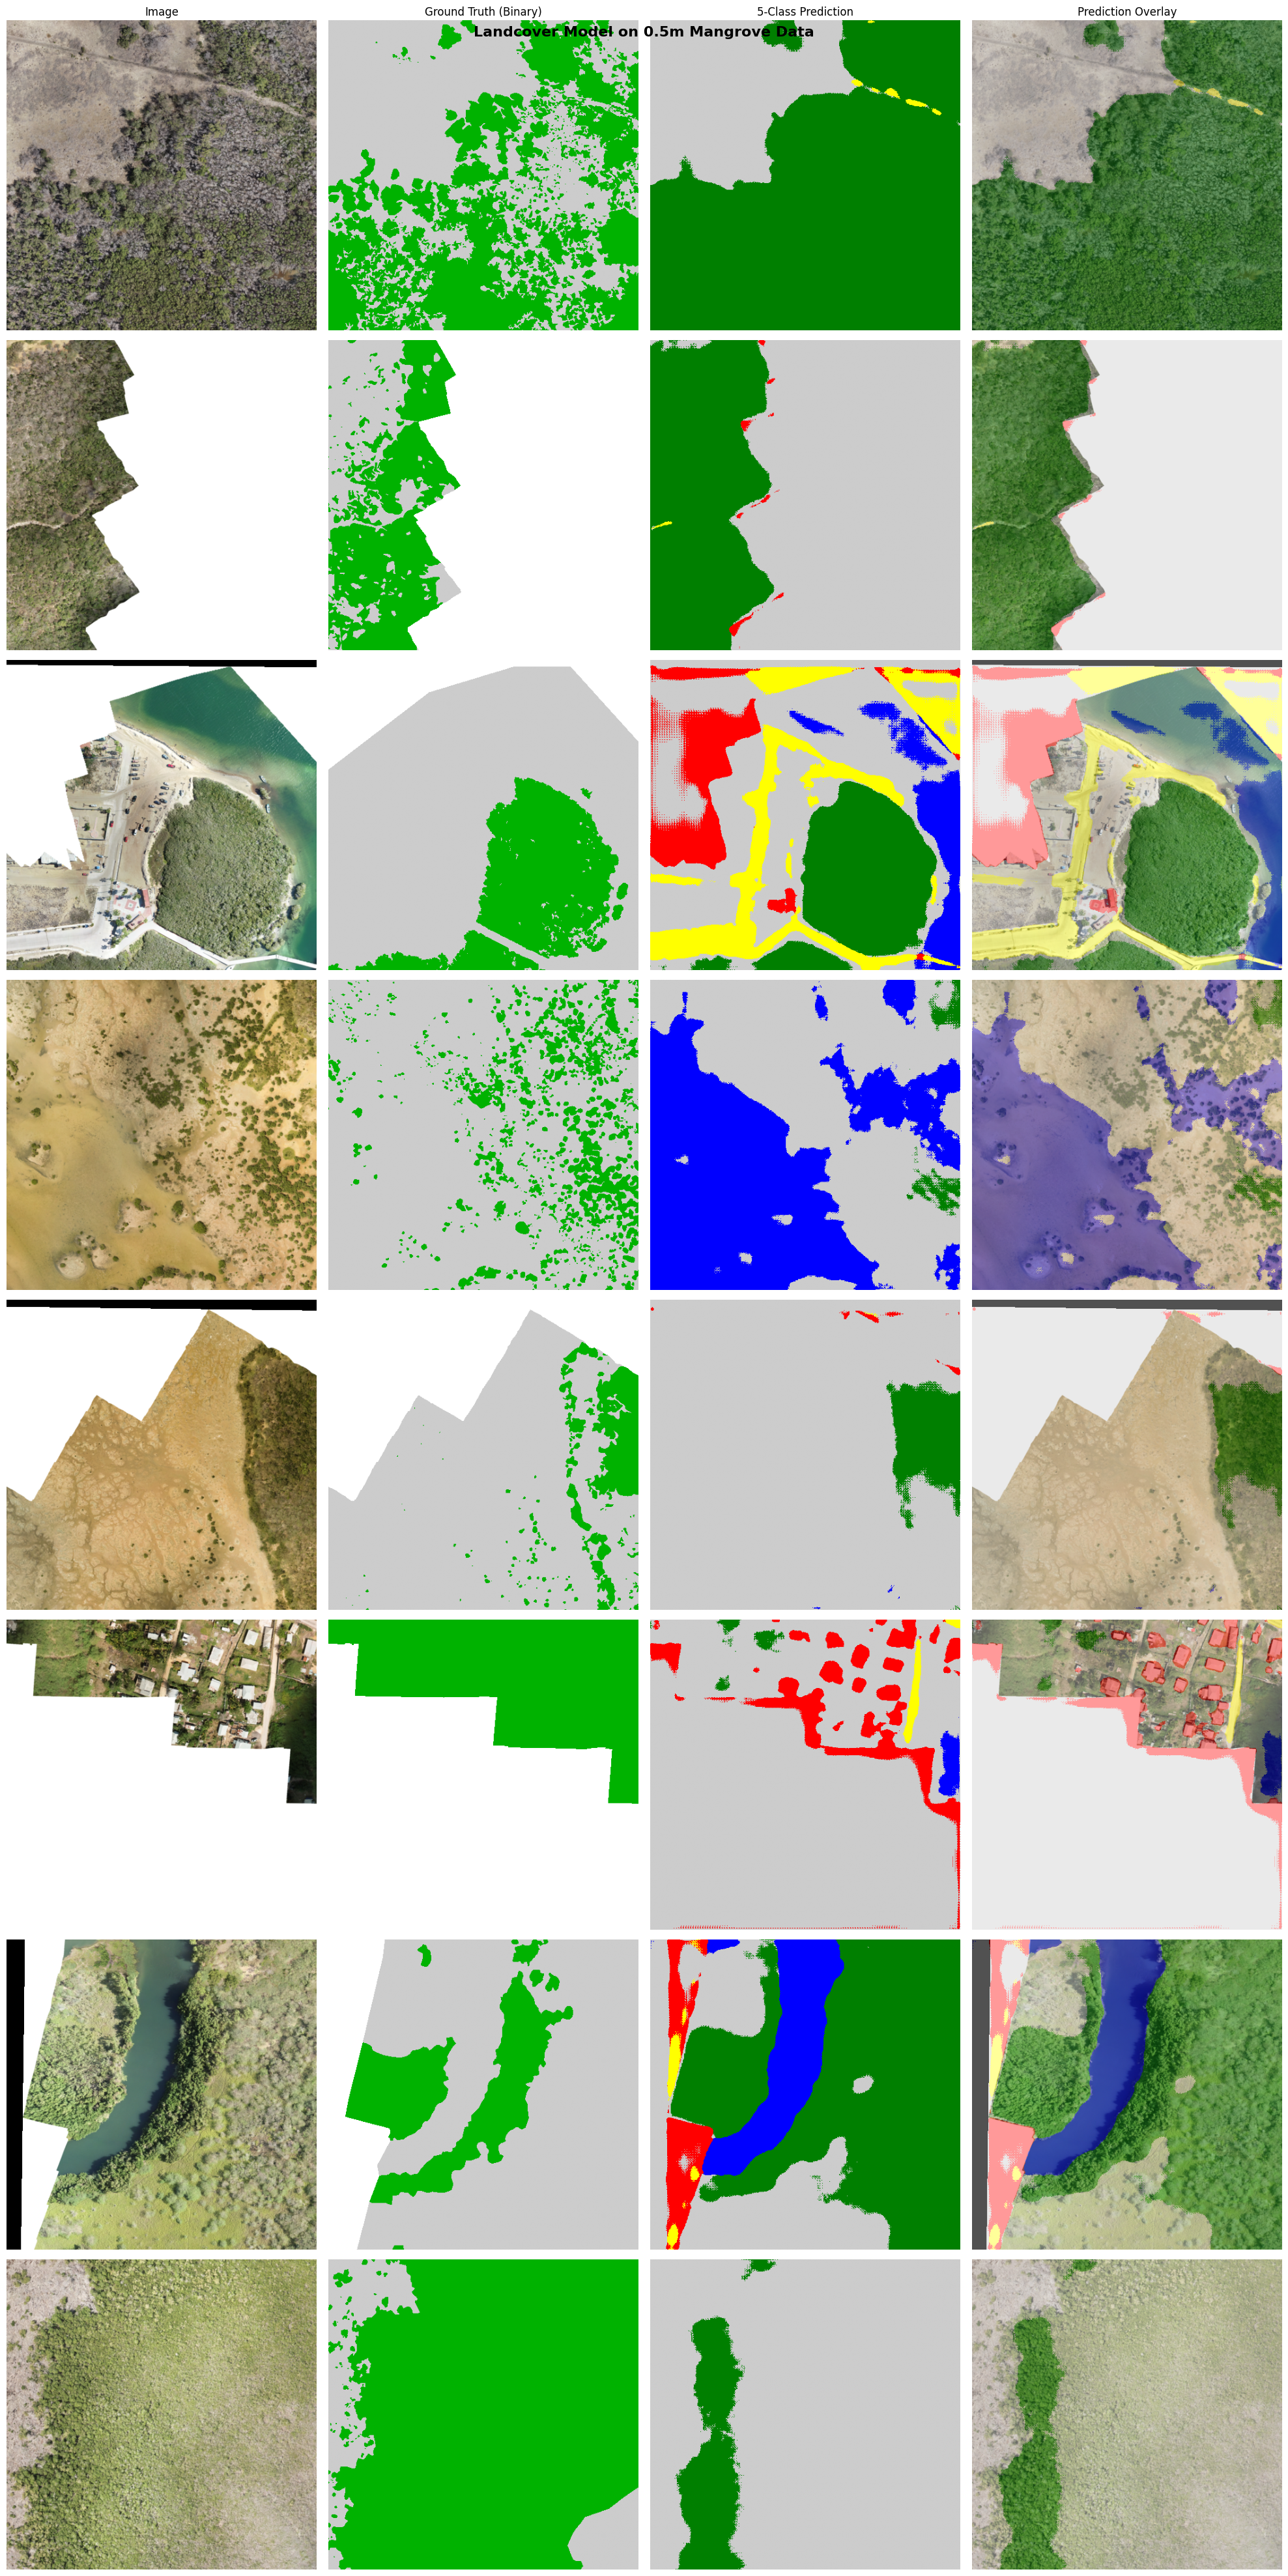

Saved: ..\plots\landcover_05m_inference\predictions_grid.png


In [10]:
print("=== Grid Visualization ===")
print()

n_samples = 8
np.random.seed(67)
sample_indices = np.random.choice(len(dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5 * n_samples))
fig.suptitle('Landcover Model on 0.5m Mangrove Data', fontsize=16, fontweight='bold')

col_titles = ['Image', 'Ground Truth (Binary)', '5-Class Prediction', 'Prediction Overlay']

model.eval()
torch.cuda.empty_cache()

with torch.no_grad():
    for row, idx in enumerate(sample_indices):
        img, mask, real_idx = dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        
        img_np = denormalize(img).numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        # Image
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_ylabel(f'idx={real_idx}', fontsize=10)
        axes[row, 0].axis('off')
        
        # Ground truth (binary mangrove colors)
        axes[row, 1].imshow(mask_to_rgb(mask_np, MANGROVE_COLORS, IGNORE_INDEX))
        axes[row, 1].axis('off')
        
        # 5-class prediction (landcover colors)
        axes[row, 2].imshow(mask_to_rgb(pred_mask, LANDCOVER_COLORS))
        axes[row, 2].axis('off')
        
        # Overlay
        pred_rgb = mask_to_rgb(pred_mask, LANDCOVER_COLORS)
        overlay = 0.6 * img_np + 0.4 * pred_rgb
        axes[row, 3].imshow(np.clip(overlay, 0, 1))
        axes[row, 3].axis('off')
        
        # Column titles on first row only
        if row == 0:
            for col, title in enumerate(col_titles):
                axes[row, col].set_title(title, fontsize=12)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'predictions_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / 'predictions_grid.png'}")

## 7. Per-Sample Inspection

Pick specific indices to examine in detail.

In [ ]:
def inspect_sample(model, dataset, idx):
    """Detailed inspection of a single sample."""
    model.eval()
    torch.cuda.empty_cache()
    
    img, mask, real_idx = dataset[idx]
    
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
    
    img_np = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    # Per-pixel class breakdown
    valid = mask_np != IGNORE_INDEX
    total_valid = valid.sum()
    
    print(f"Sample {real_idx}:")
    print(f"  GT mangrove: {(mask_np == 1).sum() / total_valid * 100:.1f}%")
    print(f"  Predictions:")
    for c in range(NUM_CLASSES):
        pct = (pred_mask[valid] == c).sum() / total_valid * 100
        print(f"    {LANDCOVER_NAMES[c]:<12}: {pct:>5.1f}%")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Sample {real_idx}', fontsize=14)
    
    axes[0].imshow(img_np)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_to_rgb(mask_np, MANGROVE_COLORS, IGNORE_INDEX))
    axes[1].set_title('Ground Truth (Binary)')
    axes[1].axis('off')
    
    axes[2].imshow(mask_to_rgb(pred_mask, LANDCOVER_COLORS))
    axes[2].set_title('Prediction (5-Class)')
    axes[2].axis('off')
    
    pred_rgb = mask_to_rgb(pred_mask, LANDCOVER_COLORS)
    overlay = 0.6 * img_np + 0.4 * pred_rgb
    axes[3].imshow(np.clip(overlay, 0, 1))
    axes[3].set_title('Overlay')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()


print("inspect_sample() defined")
print("Usage: inspect_sample(model, dataset, idx=0)")

In [ ]:
# Inspect specific samples
inspect_sample(model, dataset, 0)
inspect_sample(model, dataset, 100)
inspect_sample(model, dataset, 200)

## 8. Save Results

In [ ]:
print("=== Saving Results ===")
print()

# Build summary
valid_mask = targets_flat != IGNORE_INDEX
valid_preds = preds_flat[valid_mask]
valid_targets = targets_flat[valid_mask]

# Overall prediction counts
overall_dist = {}
for c in range(NUM_CLASSES):
    overall_dist[LANDCOVER_NAMES[c]] = float((valid_preds == c).sum() / len(valid_preds))

# Conditioned on GT
mangrove_dist = {}
nonmangrove_dist = {}
for c in range(NUM_CLASSES):
    m_mask = valid_targets == 1
    nm_mask = valid_targets == 0
    if m_mask.sum() > 0:
        mangrove_dist[LANDCOVER_NAMES[c]] = float((valid_preds[m_mask] == c).sum() / m_mask.sum())
    if nm_mask.sum() > 0:
        nonmangrove_dist[LANDCOVER_NAMES[c]] = float((valid_preds[nm_mask] == c).sum() / nm_mask.sum())

results = {
    'model': MODEL_NAME,
    'weights': str(WEIGHTS_FILE),
    'num_samples': len(dataset),
    'num_classes_model': NUM_CLASSES,
    'landcover_classes': LANDCOVER_NAMES,
    'overall_prediction_distribution': overall_dist,
    'predictions_on_mangrove_pixels': mangrove_dist,
    'predictions_on_non_mangrove_pixels': nonmangrove_dist
}

results_file = PLOTS_DIR / 'inference_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved: {results_file}")
print()
print("All outputs:")
print(f"  {PLOTS_DIR / 'class_distribution.png'}")
print(f"  {PLOTS_DIR / 'predictions_grid.png'}")
print(f"  {PLOTS_DIR / 'inference_results.json'}")

## 9. Legend

In [ ]:
# Print color legend for reference
fig, axes = plt.subplots(1, 2, figsize=(12, 2))

# Landcover legend (predictions)
for i, (name, color) in enumerate(zip(LANDCOVER_NAMES, [LANDCOVER_COLORS[c] for c in range(NUM_CLASSES)])):
    axes[0].barh(i, 1, color=color, edgecolor='black')
    axes[0].text(0.5, i, name, ha='center', va='center', fontsize=10, fontweight='bold')
axes[0].set_title('Prediction Colors (Landcover)', fontsize=11)
axes[0].set_xlim(0, 1)
axes[0].axis('off')

# Mangrove legend (ground truth)
for i, (name, color) in enumerate(zip(MANGROVE_NAMES, [MANGROVE_COLORS[c] for c in range(2)])):
    axes[1].barh(i, 1, color=color, edgecolor='black')
    axes[1].text(0.5, i, name, ha='center', va='center', fontsize=10, fontweight='bold')
axes[1].barh(2, 1, color=[1, 1, 1], edgecolor='black')
axes[1].text(0.5, 2, 'ignore (255)', ha='center', va='center', fontsize=10, fontweight='bold')
axes[1].set_title('Ground Truth Colors (Mangrove)', fontsize=11)
axes[1].set_xlim(0, 1)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'color_legend.png', dpi=150, bbox_inches='tight')
plt.show()